# **Notebook for training the data set using TensorFlow.**
Creator: Christopher Salim

This notebook is meant to be a step-by-step pedagogical explanation on how to collect the initial training data and train them.


## First of all, let's import the modules we will need in the future.

In [1]:
import keras
import tensorflow as tf
import numpy as np
import h5py
from matplotlib import pyplot as plt
import pickle
datapath = 'training_data_raw.hdf5'

Using TensorFlow backend.


## Importing the data in the form of hdf5. We will also check the data.

In [2]:
with h5py.File(datapath, 'r') as f:
    print(list(f.keys()))
    waveform_data = f['X']
    label = f['Y']
    print(waveform_data.shape)
    print(label[0:10])
    waveform_P = waveform_data[0,:,:]
    waveform_S = waveform_data[1,:,:]
    waveform_noise = waveform_data[2,:,:]
    print(waveform_P.shape)

['X', 'Y']
(4773750, 400, 3)
[0 1 2 0 2 0 2 0 1 0]
(400, 3)


## Data is OK. Label 0 means P wave, 1 means S wave, 2 means noise. Let's try to plot the example.

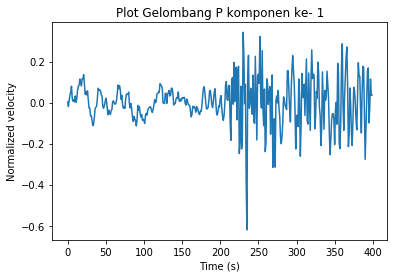

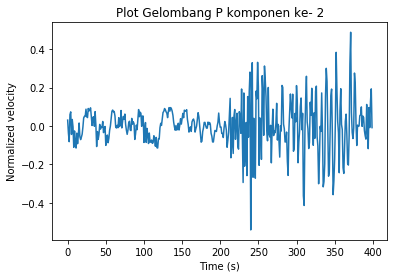

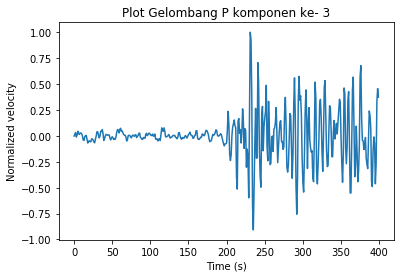

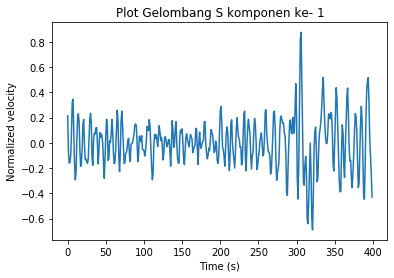

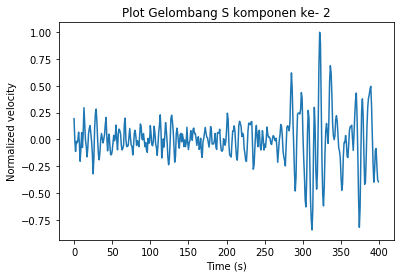

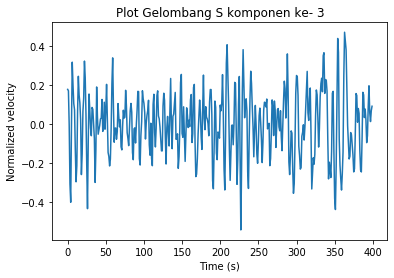

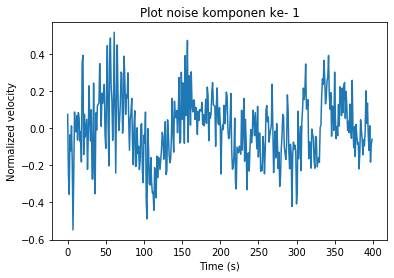

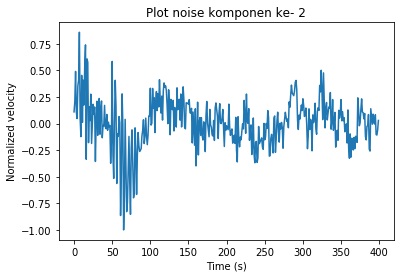

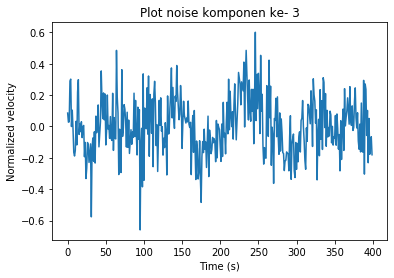

In [4]:
for k in range(0,3):
    plt.figure(k)
    plt.plot(waveform_P[:,k])
    plt.title('Plot Gelombang P komponen ke- ' + str(k+1), color='black')
    plt.xlabel('Time (s)', color='black')
    plt.ylabel('Normalized velocity', color='black')
for k in range(0,3):
    plt.figure(k+3)
    plt.plot(waveform_S[:,k])
    plt.title('Plot Gelombang S komponen ke- ' + str(k+1), color='black')
    plt.xlabel('Time (s)', color='black')
    plt.ylabel('Normalized velocity', color='black')
for k in range(0,3):
    plt.figure(k+6)
    plt.plot(waveform_noise[:,k])
    plt.title('Plot noise komponen ke- ' + str(k+1), color='black')
    plt.xlabel('Time (s)', color='black')
    plt.ylabel('Normalized velocity', color='black')


## Feed the training data. Define the function for splitting the big data into batches of data.

In [5]:
from keras.utils.io_utils import HDF5Matrix
train_start = 0
n_training_examples = int(0.76 * 4773750)
test_start = n_training_examples + 1
n_test_examples = int(0.24 * 4773750)
x_train = HDF5Matrix(datapath, 'X', train_start, train_start+n_training_examples)
y_train = HDF5Matrix(datapath, 'Y', train_start, train_start+n_training_examples)
x_test = HDF5Matrix(datapath, 'X', test_start, test_start+n_test_examples)
y_test = HDF5Matrix(datapath, 'Y', test_start, test_start+n_test_examples)
train_shape = y_train.shape[0]
test_shape = y_test.shape[0]

In [7]:
from keras.utils import to_categorical

In [45]:
from keras.models import Sequential
from keras.layers import Dense, Reshape, Conv1D, MaxPooling1D, GlobalAveragePooling1D, GaussianNoise, Dropout, Dense
num_classes = 3
model_m = Sequential()
model_m.add(Conv1D(filters=256, kernel_size=100, activation='relu', input_shape=(400, 3)))
model_m.add(Conv1D(filters=256, kernel_size=10, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(filters=64, kernel_size=10, activation='relu'))
model_m.add(Conv1D(filters=64, kernel_size=10, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.1))
model_m.add(Dense(64))
model_m.add(Dense(3, activation='softmax'))
# Specify the training configuration (optimizer, loss, metrics)
model_m.compile(optimizer='adam',  # Optimizer
              # Loss function to minimize
              loss='categorical_crossentropy',
              # List of metrics to monitor
              metrics=['categorical_accuracy'])
print(model_m.summary())

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_133 (Conv1D)          (None, 301, 256)          77056     
_________________________________________________________________
conv1d_134 (Conv1D)          (None, 292, 256)          655616    
_________________________________________________________________
max_pooling1d_47 (MaxPooling (None, 97, 256)           0         
_________________________________________________________________
conv1d_135 (Conv1D)          (None, 88, 64)            163904    
_________________________________________________________________
conv1d_136 (Conv1D)          (None, 79, 64)            41024     
_________________________________________________________________
max_pooling1d_48 (MaxPooling (None, 26, 64)            0         
_________________________________________________________________
global_average_pooling1d_30  (None, 64)              

In [7]:
#from keras.preprocessing.image import ImageDataGenerator
#aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
#	width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
#	horizontal_flip=True, fill_mode="nearest")

In [46]:
def write_log(callback, names, logs, batch_no):
    for name, value in zip(names, logs):
        summary = tf.Summary()
        summary_value = summary.value.add()
        summary_value.simple_value = value
        summary_value.tag = name
        callback.writer.add_summary(summary, batch_no)
        callback.writer.flush()

In [47]:
from keras.callbacks import TensorBoard
from keras.models import Model
epoch = 3
batch_num=4000
batchsize_train = train_shape // batch_num
batchsize_test = test_shape // batch_num
log_path = './logs'
callback = TensorBoard(log_path)
callback.set_model(model_m)
train_names = ['train_loss', 'train_accuracy']
val_names = ['val_loss', 'val_accuracy']

In [48]:
from keras.utils import to_categorical
average_train_accuracy = np.zeros((epoch, 1))
average_train_loss = np.zeros((epoch, 1))
average_test_accuracy = np.zeros((epoch, 1))
average_test_loss = np.zeros((epoch, 1))
train_loss = 0
train_accuracy = 0
test_loss = 0
test_accuracy = 0
for i in range(epoch):
    print('epoch = ' + str(i) + '---------------')
    for j in range(batch_num):
        batch_x_train = x_train[j * batchsize_train: (j + 1) * batchsize_train]
        batch_y_train = to_categorical(y_train[j * batchsize_train:(j + 1) * batchsize_train])
        batch_x_test = x_test[j * batchsize_test: (j + 1) * batchsize_test]
        batch_y_test = to_categorical(y_test[j * batchsize_test:(j + 1) * batchsize_test])
        print(batch_y_train.shape)
        print(batch_y_test.shape)
        c1 = model_m.train_on_batch(batch_x_train, batch_y_train)
        train_loss += c1[0]
        train_accuracy += c1[1]
        c2 = model_m.test_on_batch(batch_x_test, batch_y_test)
        test_loss += c2[0]
        test_accuracy += c2[1]
        print('train', c1)
        print('val', c2)
        write_log(callback, train_names, c1, i)
        write_log(callback, val_names, c2, i)
    average_train_accuracy[i] = train_accuracy/batchsize_train
    average_train_loss[i] = train_loss/batchsize_train
    average_test_accuracy[i] = test_accuracy/batchsize_test
    average_test_loss[i] = test_loss/batchsize_test    
    print('average train accuracy = ' + str(average_train_accuracy))
    print('average train loss = ' + str(average_train_loss))
    print('average test accuracy = ' + str(average_test_accuracy))
    print('average test loss = ' + str(average_test_loss))
print("end of training")

epoch = 0---------------
(907, 3)
(286, 3)
Instructions for updating:
Use tf.cast instead.


KeyboardInterrupt: 

In [ ]:
model_m.save_weights('model_weights.h5')
model_m.save('model.h5')
with open('model_architecture.json', 'w') as f:
    f.write(model_m.to_json())